In [37]:
%pylab inline 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from helper import get_colors

Populating the interactive namespace from numpy and matplotlib


In [38]:
!pwd

/Users/ntokoven/Dropbox/_Education/_UvA/_Thesis/information-bottleneck


In [116]:
get_x, get_y = lambda x: x[0], lambda x: x[1]
colors = get_colors(4)
col = {'wd':colors[0], 'dout':colors[1], 'vib':colors[2], 'ceb':colors[3]}
def get_max_from_df(df):
    #print(df.apply(get_x))
    return df.apply(get_x).max(axis=0), df.apply(get_y).max(axis=0)

In [117]:
!pwd

/Users/ntokoven/Dropbox/_Education/_UvA/_Thesis/information-bottleneck


In [118]:
date = '0506'
experiment_path = 'experiments_%s/' % date
if date == 2604:
    title = r'784->1024->1024->'+r'$\mathbf{1024}$'+r'->1024->256'
    print(title)
if date == 2104:
    title = r'784->1024->1024->'+r'$\mathbf{256}$'
    print(title)
if date == '0905':
    title = r'784->1024->1024->'+r'$\mathbf{256}$'+r'->64->64->10'
if date == '0506':
    title = r'784->1024->1024->'+r'$\mathbf{256}$'+r'->64->64->10'
print(experiment_path, title)

experiments_0506/ 784->1024->1024->$\mathbf{256}$->64->64->10


In [196]:
def make_mie_df(vals, layers, reg_type, comment=''):
    mie_df = pd.DataFrame(columns=layers)
    if reg_type == 'wd':
        folder = 'wd_whitened'
    elif reg_type == 'dout':
        folder = 'dropout'
    elif reg_type == 'vib':
        folder = 'vib'
    elif reg_type == 'vib':
        folder = 'vib'
    elif reg_type == 'ceb':
        folder = 'ceb'
    for val in vals:
        try:
            if comment != '':
                path = experiment_path + 'mie/%s/%s/%s' % (comment, folder, str(val))
            else:
                path = experiment_path + 'mie/%s/%s' % (folder, str(val))
            path += '/mie_max_values'
            f_names = sort(os.listdir(path))
            for j in range(len(f_names)):
                if f_names[j] != '.DS_Store':
                    for layer in layers:
                        name = re.findall('Linear%d' % layer, f_names[j])
                        if len(name) > 0:
                            name = name[0]
                            layer = int(re.sub('\D', '', name))

                            res_str = pd.Series.from_csv(path+'/'+f_names[j], sep=' ')[name]
                            mie_df.loc[val, layer] = [float(_) for _ in re.sub('[(]|[)]', '', res_str).split(', ')]
        except FileNotFoundError:
            print('MIE experiment for %s with %s (%s) is missing' % (comment, reg_type, val))
    return mie_df

def make_abc_df(vals, layers, reg_type, comment=''):
    abc_df = pd.DataFrame(columns=layers)
    if reg_type == 'wd':
        folder = 'wd_whitened'
    elif reg_type == 'dout':
        folder = 'dropout'
    elif reg_type == 'vib':
        folder = 'vib'
    elif reg_type == 'ceb':
        folder = 'ceb'
    path = experiment_path + 'results/abc_values/%s/' % comment
    f_names = sort(os.listdir(path))
    print(f_names)
    for j in range(len(f_names)):
        if f_names[j] != '.DS_Store':
            for val in vals:
                for layer in layers:
                    target_name = re.compile(r'%s_{[0-9]}_%s' % (reg_type, val))
                    for num in range(0, len(vals)):
                        if os.path.exists(path+r'%s_{%d}_%s.csv' % (reg_type, num, val)):
                            name = path+r'%s_{%d}_%s.csv' % (reg_type, num, val)
                            try:
                                a = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[0]['Linear%d'%layer]
                                b = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[1]['Linear%d'%layer]
                                abc_df.loc[val, layer] = (a, b)
                            except:
                                a = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[0]['Linear0']
                                b = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[1]['Linear0']
                                abc_df.loc[val, layer] = (a, b)
    return abc_df

def information_plane(mi_df, abc_df, reg_type, fig, ax, c=False, name=False, loc=False, title=False, comment=''):
    params_vals = mi_df.index.values
    layers = mi_df.columns.values
    colors = get_colors(len(layers))
    set_legend = True
    for j in range(len(layers)):
        l = layers[j]
        for i in range(len(params_vals)):
            try:
                p = params_vals[i]
                if set_legend:
                    ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], color=c if c else colors[l], label='reg_type=%s, %s' % (reg_type, comment))
                    ax.legend(loc=loc if loc else 'best')#4)
                else:
                    ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], color=c if c else colors[l])
                ax.annotate('(%s, (%.3f, %.3f))' % (p, abc_df.loc[p, l][0], abc_df.loc[p, l][1]), (mi_df.loc[p, l][0]+0.02, mi_df.loc[p, l][1]))
    #             ax.annotate('%s %s' % (reg_type, p), (mi_df.loc[p, l][0]+0.01, mi_df.loc[p, l][1]-0.0075))
                ax.grid()
                set_legend = False
            except KeyError:
                print('GC experiment for %s with %s (%s) is missing' % (comment, reg_type, p))
        if not c:
            set_legend = True
        ax.plot(mi_df[l].apply(get_x).values, mi_df[l].apply(get_y).values, color=c if c else colors[l])
        ax.set_title(title if title else reg_type+' (param_val, ABC)')

    fig.text(0.5, 0.04, 'I(X, Z)', ha='center')
    fig.text(0.04, 0.5, 'I(Z, Y)', va='center', rotation='vertical')
    fig.set_size_inches(10, 7, forward=True)
    if not os.path.exists(experiment_path+'results/information_planes'):
        os.makedirs(experiment_path+'results/information_planes')
    fig.show()
    fig.savefig(experiment_path+'results/information_planes/%s.png' % name if name else reg_type)
    print('saved information plane')
    return fig, ax

In [197]:
'''
#Weight decay and dropout 
layers = [2]#[0, 1, 2]#'Linear0', 'Linear1', 'Linear2']
colors = get_colors(4)
col = {'wd':colors[0], 'dout':colors[1], 'vib':colors[2], 'ceb':colors[3]}
wd_vals = ['0', '1e-6', '5e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2']

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

wd_abc = make_abc_df(wd_vals, layers, 'wd')
wd_mie = make_mie_df(wd_vals, layers, 'wd')
_ = information_plane(wd_mie, wd_abc, 'wd', fig, ax, col['wd'], title=title)
title

layers = [2]

do_vals = ['0', '0.05', '0.1', '0.2', '0.325', '0.45', '0.6', '0.75']#, '0.9']
do_mie = make_mie_df(do_vals, layers, 'dout')
do_abc = make_abc_df(do_vals, layers, 'dout')

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
information_plane(do_mie, do_abc, 'do', fig, ax, col['dout'],title=title)
plt.show()
'''

"\n#Weight decay and dropout \nlayers = [2]#[0, 1, 2]#'Linear0', 'Linear1', 'Linear2']\ncolors = get_colors(4)\ncol = {'wd':colors[0], 'dout':colors[1], 'vib':colors[2], 'ceb':colors[3]}\nwd_vals = ['0', '1e-6', '5e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2']\n\nfig, ax = plt.subplots(1, 1, sharex=True, sharey=True)\n\nwd_abc = make_abc_df(wd_vals, layers, 'wd')\nwd_mie = make_mie_df(wd_vals, layers, 'wd')\n_ = information_plane(wd_mie, wd_abc, 'wd', fig, ax, col['wd'], title=title)\ntitle\n\nlayers = [2]\n\ndo_vals = ['0', '0.05', '0.1', '0.2', '0.325', '0.45', '0.6', '0.75']#, '0.9']\ndo_mie = make_mie_df(do_vals, layers, 'dout')\ndo_abc = make_abc_df(do_vals, layers, 'dout')\n\nfig, ax = plt.subplots(1, 1, sharex=True, sharey=True)\ninformation_plane(do_mie, do_abc, 'do', fig, ax, col['dout'],title=title)\nplt.show()\n"

In [198]:
ceb_mie_mnist

,2
0,"[10.36736860433461, 2.341405718106229]"
1e-6,"[11.012876711750483, 2.3474309729738825]"
1e-3,"[3.071604062313152, 2.3500623434640784]"
1,"[2.337773593963605, 2.289109320013444]"


In [199]:
layers = [2]
# ceb_vals = ['0', '1e-10', '1e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '5e-1']#, '1e-0']
# ceb_vals = ['0', '1e-10', '1e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '5e-1']#, '1e-0']
ceb_vals = ['0', '1e-10', '1e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '5e-2', '1e-1', '5e-1', '1', '5']

# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
vib_mie_12k_train = make_mie_df(ceb_vals, layers, 'vib', comment='mnist12k')
ceb_mie_12k_test = make_mie_df(ceb_vals, layers, 'ceb', comment='mnist12k_on_test')
ceb_mie_12k_train = make_mie_df(ceb_vals, layers, 'ceb', comment='mnist12k')

ceb_mie_mnist = make_mie_df(ceb_vals, layers, 'ceb', comment='mnist')



# information_plane(ceb_mie, ceb_abc, 'ceb', fig, ax, col['ceb'], title=title)

MIE experiment for mnist12k_on_test with ceb (1e-10) is missing
MIE experiment for mnist12k_on_test with ceb (1e-9) is missing
MIE experiment for mnist12k_on_test with ceb (1e-8) is missing
MIE experiment for mnist12k_on_test with ceb (1e-7) is missing
MIE experiment for mnist12k_on_test with ceb (1e-5) is missing
MIE experiment for mnist12k_on_test with ceb (1e-4) is missing
MIE experiment for mnist12k_on_test with ceb (1e-2) is missing
MIE experiment for mnist12k_on_test with ceb (5e-2) is missing
MIE experiment for mnist12k_on_test with ceb (1e-1) is missing
MIE experiment for mnist12k_on_test with ceb (5e-1) is missing
MIE experiment for mnist12k_on_test with ceb (5) is missing
MIE experiment for mnist with ceb (1e-10) is missing
MIE experiment for mnist with ceb (1e-9) is missing
MIE experiment for mnist with ceb (1e-8) is missing
MIE experiment for mnist with ceb (1e-7) is missing
MIE experiment for mnist with ceb (1e-5) is missing
MIE experiment for mnist with ceb (1e-4) is miss

In [200]:
ceb_abc_12k_train = make_abc_df(ceb_vals, layers, 'ceb', comment='mnist12k')
ceb_abc_mnist = make_abc_df(ceb_vals, layers, 'ceb', comment='mnist')
#vib_abc_12k_train = make_abc_df(ceb_vals, layers, 'vib', comment='mnist')

['ceb_{0}_0.csv' 'ceb_{10}_5e-2.csv' 'ceb_{11}_1e-1.csv'
 'ceb_{12}_5e-1.csv' 'ceb_{13}_1.csv' 'ceb_{14}_5.csv' 'ceb_{1}_1e-10.csv'
 'ceb_{5}_1e-6.csv' 'ceb_{7}_1e-4.csv' 'ceb_{8}_1e-3.csv']


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:57: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:58: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


['ceb_{0}_0.csv' 'ceb_{13}_1.csv' 'ceb_{5}_1e-6.csv' 'ceb_{8}_1e-3.csv']


GC experiment for mnist12k with ceb (1e-9) is missing
GC experiment for mnist12k with ceb (1e-8) is missing
GC experiment for mnist12k with ceb (1e-7) is missing
GC experiment for mnist12k with ceb (1e-5) is missing
GC experiment for mnist12k with ceb (1e-2) is missing
saved information plane


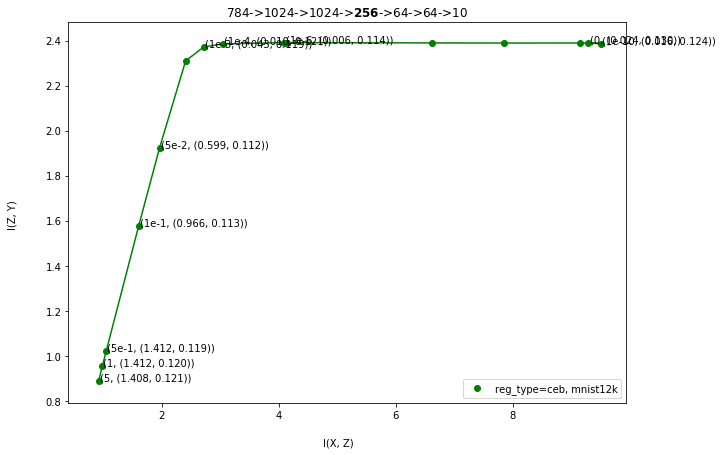

In [201]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig, ax = information_plane(ceb_mie_12k_train, ceb_abc_12k_train, 'ceb', fig, ax, col['ceb'], title=title, comment='mnist12k')
fig.show()
fig.savefig(experiment_path+'results/information_planes/mnist12k_train.png')

saved information plane


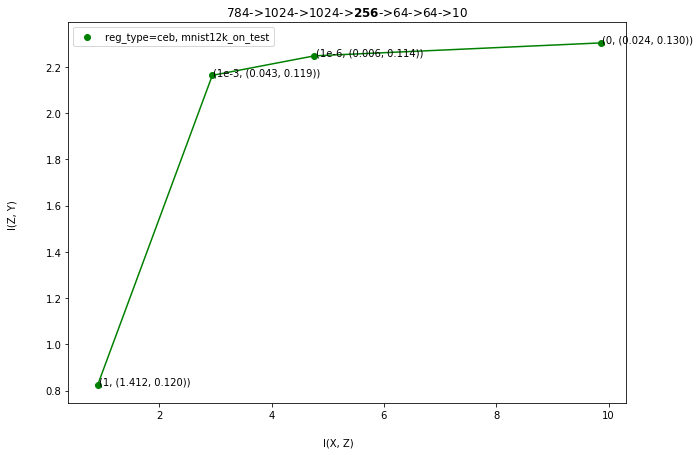

In [202]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig, ax = information_plane(ceb_mie_12k_test, ceb_abc_12k_train, 'ceb', fig, ax, col['ceb'], title=title, comment='mnist12k_on_test')
fig.show()
fig.savefig(experiment_path+'results/information_planes/mnist12k_test.png')

saved information plane


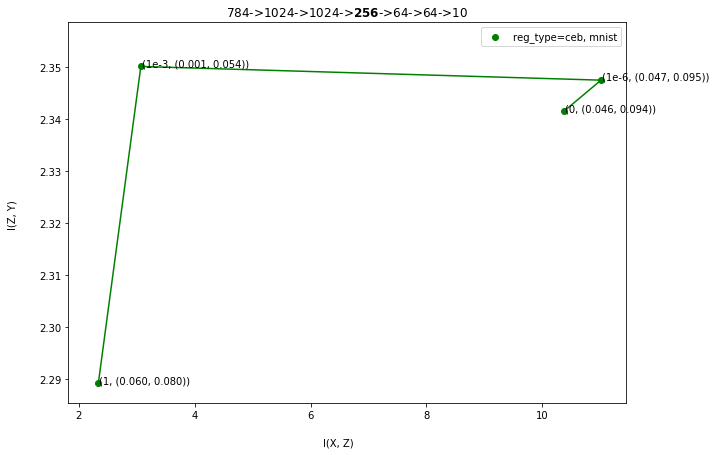

In [203]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig, ax = information_plane(ceb_mie_mnist, ceb_abc_mnist, 'ceb', fig, ax, col['ceb'], title=title, comment='mnist')
fig.show()
fig.savefig(experiment_path+'results/information_planes/mnist.png')

saved information plane
GC experiment for mnist12k with ceb (1e-9) is missing
GC experiment for mnist12k with ceb (1e-8) is missing
GC experiment for mnist12k with ceb (1e-7) is missing
GC experiment for mnist12k with ceb (1e-5) is missing
GC experiment for mnist12k with ceb (1e-2) is missing
saved information plane


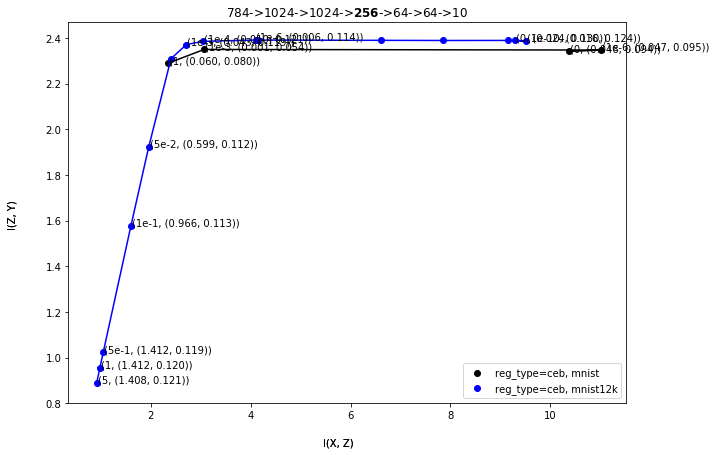

In [206]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig, ax = information_plane(ceb_mie_mnist, ceb_abc_mnist, 'ceb', fig, ax, col['wd'], title=title, comment='mnist')
fig, ax = information_plane(ceb_mie_12k_train, ceb_abc_12k_train, 'ceb', fig, ax, col['dout'], title=title, comment='mnist12k')
# fig, ax = information_plane(ceb_mie_12k_test, ceb_abc_12k_train, 'ceb', fig, ax, col['ceb'], title=title, comment='mnist12_on_test')

# fig.savefig(experiment_path+'results/information_planes/train_vs_test.png')#all_in.png')
fig.savefig(experiment_path+'results/information_planes/mnist_vs_12k.png')#all_in.png')

In [180]:
ceb_abc_12k_train

,2
0,"(0.024053064035215312, 0.1300817590438098)"
1e-10,"(0.016295933027100144, 0.12444399402751585)"
1e-6,"(0.006442711610068057, 0.1137959610208894)"
1e-4,"(0.010231554154950159, 0.12129446769788152)"
1e-3,"(0.04301194832823674, 0.11871336125755964)"
5e-2,"(0.5987417330395817, 0.1120021985342268)"
1e-1,"(0.966286669200764, 0.11314069397782794)"
5e-1,"(1.4123699537156105, 0.11925250597979377)"
1,"(1.412192024678662, 0.11976162295996028)"
5,"(1.407674489856281, 0.1212990584053152)"


784->1024->1024->$\mathbf{256}$
experiments_2104/


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


saved information plane


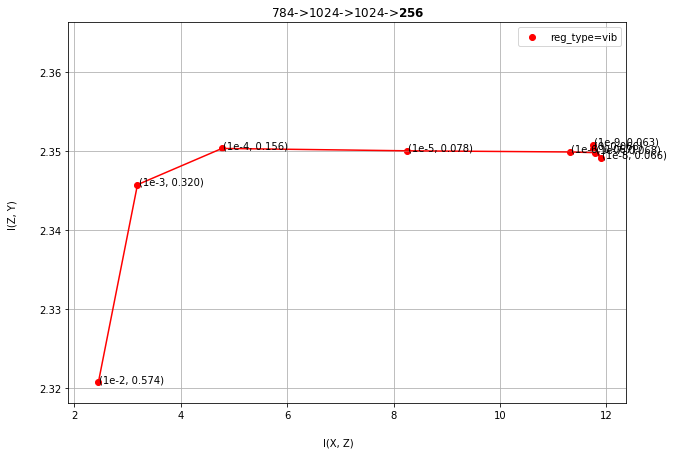

In [586]:
'''
date = 2104
experiment_path = 'experiments_%s/' % date
if date == 2604:
    title = r'784->1024->1024->'+r'$\mathbf{1024}$'+r'->1024->256'
    print(title)
if date == 2104:
    title = r'784->1024->1024->'+r'$\mathbf{256}$'
    print(title)
print(experiment_path)
'''

layers = [2]
vib_vals = ['0', '1e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2']#, '1e-1', '1e-0']
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
vib_mie = make_mie_df(vib_vals, layers, 'vib')
vib_abc = make_abc_df(vib_vals, layers, 'vib')
vib_mie

fig, ax = information_plane(vib_mie, vib_abc, 'vib', fig, ax, col['vib'], title=title)
fig.savefig('presentation.png')

KeyError: '0'

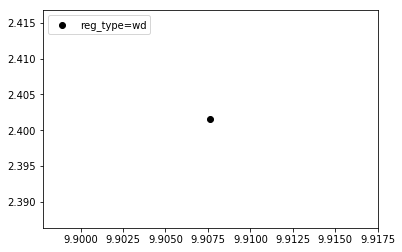

In [587]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

fig, ax = information_plane(wd_mie, wd_abc, 'wd', fig, ax, col['wd'], 'allin1', 2, title=title)
fig, ax = information_plane(do_mie, do_abc, 'do', fig, ax, col['dout'], 'allin1', 2, title=title)
fig, ax = information_plane(vib_mie, vib_abc, 'vib', fig, ax, col['vib'], 'allin1', 2, title=title)


In [532]:
##########
# Colored MNIST 

data = np.load('/Users/ntokoven/_colored_mnist/mnist_10color_jitter_var_0.050.npy', encoding='latin1')
data

array({'test_image': array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0

In [554]:
# from cmnist_data_loader import WholeDataLoader
import cmnist_data_loader
data_dir = '/Users/ntokoven/_colored_mnist/'
print(data_dir)
option = {'data_dir': data_dir, 'data_split': 'train'}

custom_loader = cmnist_data_loader.WholeDataLoader(option)#data_dir)#, 'train')
trainval_loader = torch.utils.data.DataLoader(custom_loader,
                                              batch_size=64,
                                              shuffle=True,
                                              num_workers=1)

/Users/ntokoven/_colored_mnist/


AttributeError: 'dict' object has no attribute 'data_split'

In [546]:
!cat cmnist_data_loader.py

# -*- coding: utf-8 -*-
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os


import torch.utils.data as data
import torchvision.datasets as datasets


class WholeDataLoader(Dataset):
    def __init__(self, data_dir, data_split, color_var = 0.05):
        # self.data_split = option.data_split
        data_dic = np.load(os.path.join(data_dir,'mnist_10color_jitter_var_%.03f.npy' % color_var), encoding = 'latin1').item()
        if self.data_split == 'train':
            self.image = data_dic['train_image']
            self.label = data_dic['train_label']
        elif self.data_split == 'test':
            self.image = data_dic['test_image']
            self.label = data_dic['test_label']
            

        
        self.color_std = color_var**0.5

        self.T = transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Norm